# Geospatial Analysis

repository link: https://github.com/matteo-torres/climate-geospatial

## Load packages

In [25]:
import s3fs
import intake
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

## Read data

In [26]:
# CMIP6 catalog
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

## Data exploration

In [27]:
# Catalog search
res = catalog.search(activity_id = ["CMIP", "ScenarioMIP"], # Historical data and future projections
                     source_id = ["GFDL-CM4", "GFDL-ESM4"], # NOAA models (Global Climate Model, Earth Systems)
                     experiment_id = ["historical", "ssp585"], # Fossil fueled development
                     table_id = "Amon", # Atmospheric monthly data
                     member_id = "r1i1p1f1", # Variant ID
                     variable_id = "tas") # Surface air temperature

# View results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/h...,NaN,20180701
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


The models I chose are from NOAA’s Geophysical Fluid Dynamics Laboratory (GFDL): CM4 and ESM4. The CM4 model is a climate model that helps scientists understand how the atmosphere, oceans, land, and sea ice work together to shape our climate. The ESM4 model is a more advanced version that also includes how carbon and other natural processes, like forests and ocean life, interact with the climate over time. I also chose to use the SSP5-8.5 scenario, which represents a future with high greenhouse gas emissions driven by continued fossil fuel use.

## Extract data

In [28]:
# Read in the historical data file for CM4
hist_CM4 = xr.open_zarr(res.df["zstore"][1], storage_options = {"anon": True})

# Read in the ssp585 data file for CM4
ssp585_CM4 = xr.open_zarr(res.df["zstore"][0], storage_options = {"anon": True})

In [29]:
# Read in the historical data file for ESM4
hist_ESM4 = xr.open_zarr(res.df["zstore"][3], storage_options = {"anon": True})

# Read in the ssp585 data file for ESM4
ssp585_ESM4 = xr.open_zarr(res.df["zstore"][2], storage_options = {"anon": True})

## Data cleaning

In [30]:
# Concatenate data
CM4_data = xr.concat([hist_CM4, ssp585_CM4], dim = "time")
ESM4_data = xr.concat([hist_ESM4, ssp585_ESM4], dim = "time")

# Convert time to datetime64 format
CM4_data["time"] = CM4_data.time.astype("datetime64[ns]")
ESM4_data["time"] = ESM4_data.time.astype("datetime64[ns]")

In [31]:
# Extract surface air temperature variable
CM4_tas = CM4_data["tas"]
ESM4_tas = ESM4_data["tas"]

In [32]:
# Define min/max bounds for region of interest (Greenland)
lat_min, lat_max = 59.8, 83.6
lon_min, lon_max = 287.0, 349.0

I chose to analyze the surface air temperature trends in Greenland due to the region’s sensitivity to climate change and the critical role its ice sheet plays in regulating global sea levels. Greenland has an Arctic tundra climate, with average surface temperatures rarely exceeding a mean of 5.6°C. Given the rapid warming observed in polar regions, I am particularly interested in how surface temperatures in Greenland have changed over time, especially under an extreme climate scenario such as SSP5-8.5, which represents continued fossil fuel development. 

In [33]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
lat_CM4_tas = (CM4_tas.lat >= lat_min) & (CM4_tas.lat <= lat_max)
lon_CM4_tas = (CM4_tas.lon >= lon_min) & (CM4_tas.lon <= lon_max)

lat_ESM4_tas = (ESM4_tas.lat >= lat_min) & (ESM4_tas.lat <= lat_max)
lon_ESM4_tas = (ESM4_tas.lon >= lon_min) & (ESM4_tas.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_CM4 = CM4_tas.where(lat_CM4_tas & lon_CM4_tas, drop = True)
tas_ESM4 = ESM4_tas.where(lat_ESM4_tas & lon_ESM4_tas, drop = True)

# Average over lat, lon dimensions to get a time series
CM4_avg = tas_CM4.mean(dim = ["lat", "lon"])
ESM4_avg = tas_ESM4.mean(dim = ["lat", "lon"])

# Sort by time
CM4_sort = CM4_avg.sortby("time")
ESM4_sort = ESM4_avg.sortby("time")

In [34]:
# Subset CM4 and ESM4 temperature data for each time period
CM4_period1 = CM4_sort.sel(time = slice("1950-01", "1989-12"))
CM4_period2 = CM4_sort.sel(time = slice("2060-01", "2099-12"))

ESM4_period1 = ESM4_sort.sel(time = slice("1950-01", "1989-12"))
ESM4_period2 = ESM4_sort.sel(time = slice("2060-01", "2099-12"))

## CM4 Model

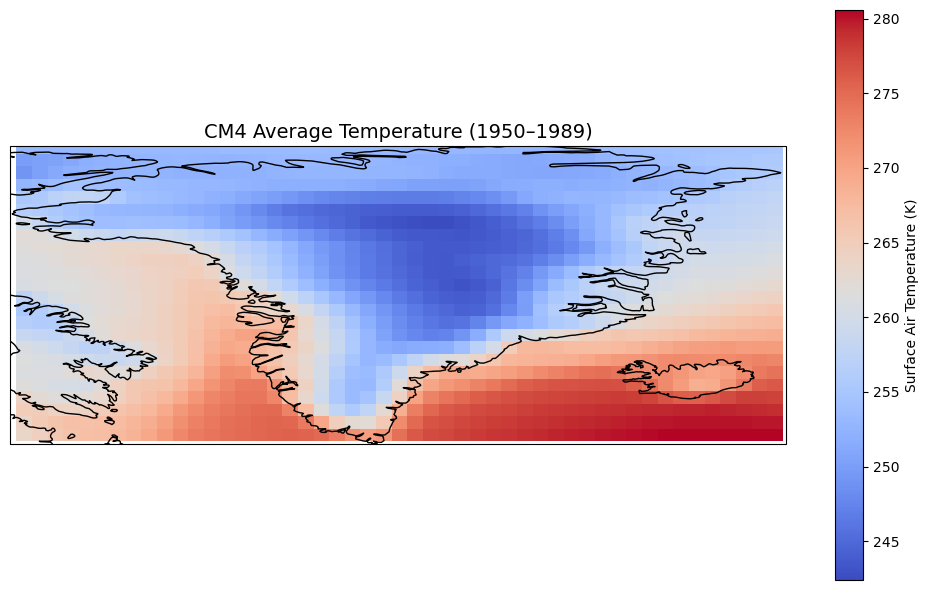

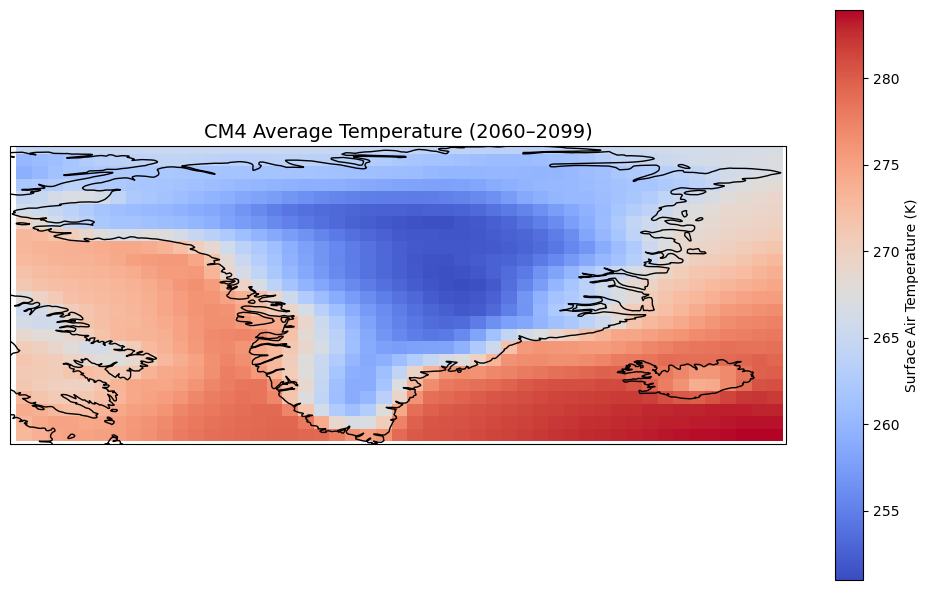

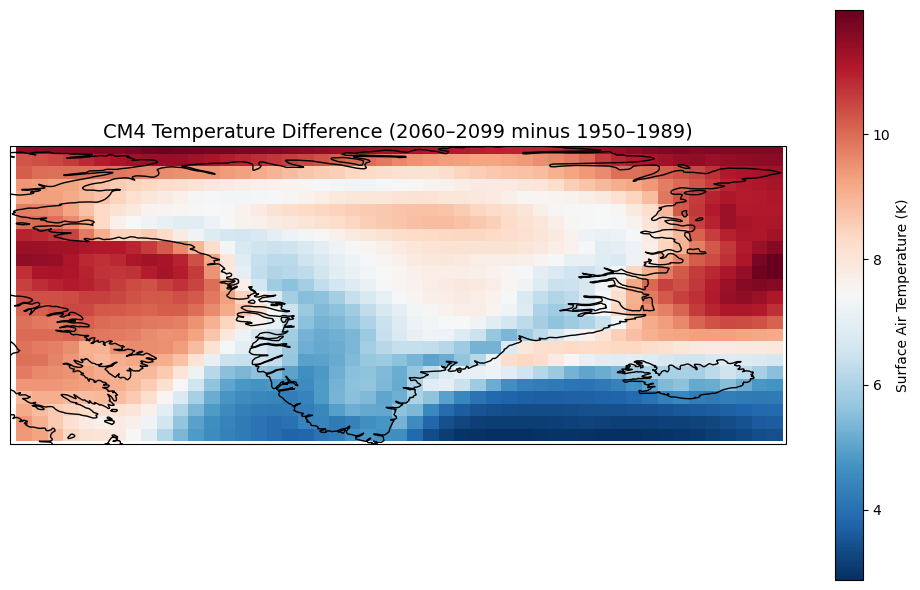

In [39]:
# Subset full spatial data, not just averages
CM4_period1_map = tas_CM4.sel(time = slice("1950-01", "1989-12")).mean(dim = "time")
CM4_period2_map = tas_CM4.sel(time = slice("2060-01", "2099-12")).mean(dim = "time")

# Calculate difference (Future - Historical)
CM4_diff_map = CM4_period2_map - CM4_period1_map

# Plotting function
def plot_map(data, title, cmap = "coolwarm", vmin = None, vmax = None):
    plt.figure(figsize = (10, 6))
    ax = plt.axes(projection = ccrs.PlateCarree())
    data.plot(ax = ax,
              cmap = cmap, 
              vmin = vmin, 
              vmax = vmax, 
              cbar_kwargs = {"label": "Surface Air Temperature (K)"})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(title, fontsize=14)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    plt.tight_layout()
    plt.show()
    
# Plot maps
plot_map(CM4_period1_map, "CM4 Average Temperature (1950–1989)")
plot_map(CM4_period2_map, "CM4 Average Temperature (2060–2099)")
plot_map(CM4_diff_map, "CM4 Temperature Difference (2060–2099 minus 1950–1989)", cmap = "RdBu_r")

## ESM4 Model

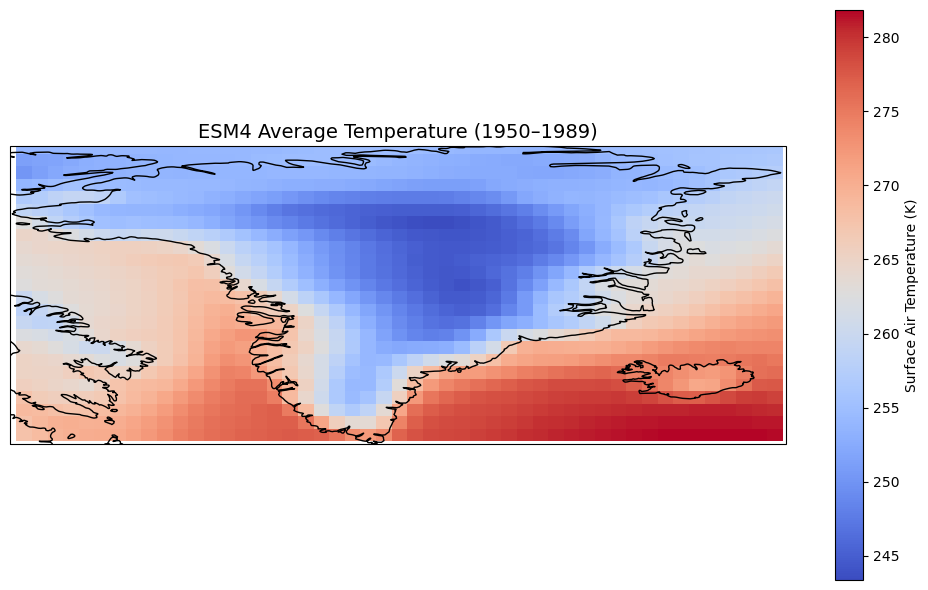

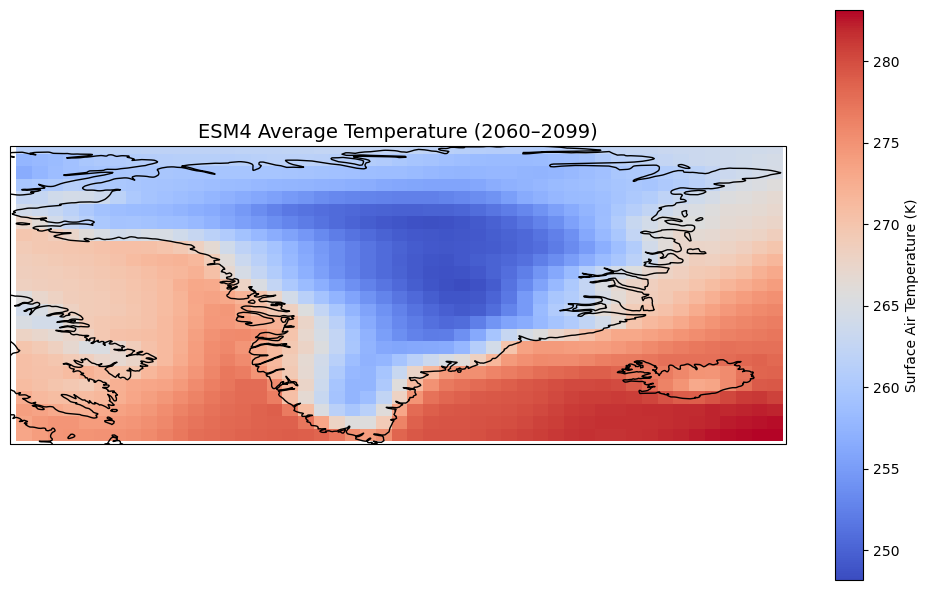

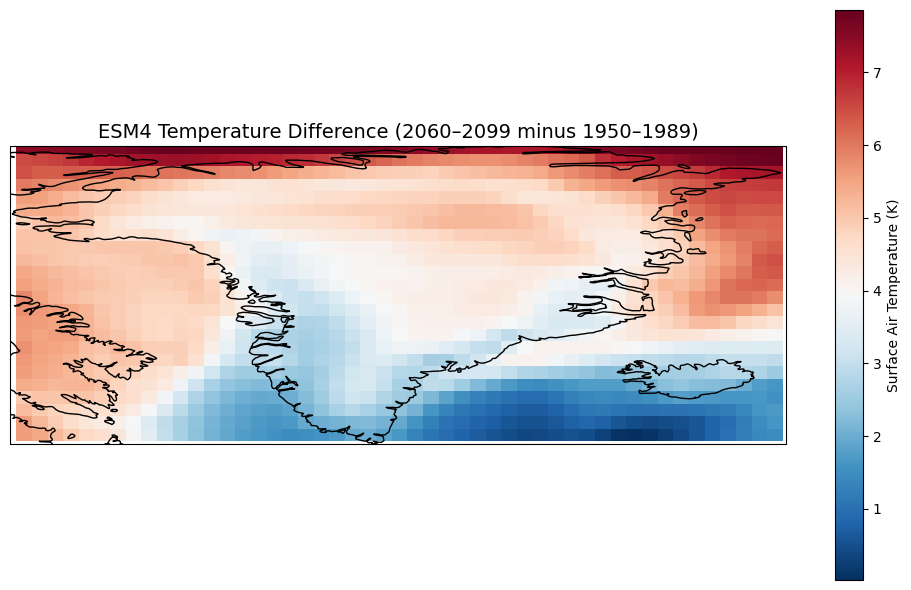

In [41]:
# Subset full spatial data for ESM4
ESM4_period1_map = tas_ESM4.sel(time = slice("1950-01", "1989-12")).mean(dim = "time")
ESM4_period2_map = tas_ESM4.sel(time = slice("2060-01", "2099-12")).mean(dim = "time")

# Calculate difference (Future - Historical)
ESM4_diff_map = ESM4_period2_map - ESM4_period1_map

# Plot maps
plot_map(ESM4_period1_map, "ESM4 Average Temperature (1950–1989)")
plot_map(ESM4_period2_map, "ESM4 Average Temperature (2060–2099)")
plot_map(ESM4_diff_map, "ESM4 Temperature Difference (2060–2099 minus 1950–1989)", cmap = "RdBu_r")